In [7]:

import pandas as pd
import numpy as np
import math
from scipy.stats import norm
from scipy.optimize import brentq  # A common root-finding algorithm for IV

In [8]:
# Cell 2: Black-Scholes Formulas and Greeks (for European Calls)

def black_scholes_call(S, K, T, r, sigma):
    """
    Calculates the Black-Scholes price for a European call option.

    Args:
        S (float): Current underlying asset price
        K (float): Option strike price
        T (float): Time to expiration (in years)
        r (float): Risk-free interest rate (annualized)
        sigma (float): Volatility of the underlying asset (annualized)

    Returns:
        float: Call option price
    """
    if sigma <= 0 or T <= 0: # Avoid division by zero or log of non-positive
        # If option is in the money, price is at least S - K*exp(-r*T), otherwise 0
        return max(0.0, S - K * np.exp(-r * T))

    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    call_price = (S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2))
    return call_price

def delta_call(S, K, T, r, sigma):
    """Calculates the Delta for a European call option."""
    if sigma <= 0 or T <= 0:
        # Delta is 1 if deep ITM, 0 if OTM/ATM at expiry/no vol
        return 1.0 if S > K else 0.0
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    delta = norm.cdf(d1)
    return delta

def gamma(S, K, T, r, sigma):
    """Calculates the Gamma for a European option (same for call/put)."""
    if sigma <= 0 or T <= 0:
        return 0.0
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    gamma_val = norm.pdf(d1) / (S * sigma * np.sqrt(T))
    return gamma_val

def vega(S, K, T, r, sigma):
    """Calculates the Vega for a European option (same for call/put)."""
    # Vega is per 1% change in vol, so we divide by 100 at the end if needed,
    # but often it's left as is (per 1 vol point change, e.g. 0.20 to 0.21)
    if sigma <= 0 or T <= 0:
        return 0.0
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    vega_val = S * norm.pdf(d1) * np.sqrt(T)
    # return vega_val / 100 # Uncomment if you want Vega per 1%
    return vega_val

def theta_call(S, K, T, r, sigma):
    """Calculates the Theta for a European call option."""
    # Theta is typically quoted per day, so we divide by 365
    if sigma <= 0 or T <= 0:
        return 0.0 # No time decay if already expired or no volatility
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    theta_val = -(S * norm.pdf(d1) * sigma) / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * norm.cdf(d2)
    return theta_val / 365.0 # Per day

In [9]:
# Cell 3: Implied Volatility Calculation Function

def calculate_implied_volatility(market_price, S, K, T, r, max_iterations=100, tolerance=1e-5):
    """
    Calculates the implied volatility using the brentq root-finding algorithm.

    Args:
        market_price (float): The observed market price of the option
        S (float): Current underlying asset price
        K (float): Option strike price
        T (float): Time to expiration (in years)
        r (float): Risk-free interest rate (annualized)
        max_iterations (int): Max iterations for solver
        tolerance (float): Precision tolerance for solver

    Returns:
        float: Implied Volatility (annualized), or np.nan if not found
    """
    if T <= 0 or market_price <= 0:
        return np.nan

    # Function whose root we want to find (difference between BS price and market price)
    def price_difference(sigma):
        if sigma < 0.0001: # Prevent issues with sigma too close to zero
             sigma = 0.0001
        return black_scholes_call(S, K, T, r, sigma) - market_price

    # We need bounds for the volatility search. 0.1% to 500% is usually wide enough.
    vol_low = 0.001
    vol_high = 5.0

    try:
        # Check if the market price is below intrinsic value (arbitrage?)
        intrinsic_value = max(0.0, S - K * np.exp(-r * T))
        if market_price < intrinsic_value - tolerance: # Allow for small tolerance
            # print(f"Warning: Market price {market_price} below intrinsic value {intrinsic_value} for S={S}, K={K}, T={T}")
            return np.nan # Cannot find positive volatility

        # Check if vol_high is high enough (price at vol_high should be > market_price)
        if price_difference(vol_high) < 0:
             # print(f"Warning: Market price {market_price} is higher than price at max vol {vol_high}. Increase vol_high? S={S}, K={K}, T={T}")
             # Try extending the upper bound significantly
             vol_high = 10.0
             if price_difference(vol_high) < 0:
                  return np.nan

        # Check if vol_low is low enough (price at vol_low should be < market_price)
        # If market price is *very* close to intrinsic value, IV might be near zero.
        if price_difference(vol_low) > 0 and abs(market_price - intrinsic_value) > tolerance:
              # print(f"Warning: Market price {market_price} is lower than price at min vol {vol_low}. Decrease vol_low? S={S}, K={K}, T={T}")
              # This case is less common unless market price is below intrinsic
              return np.nan


        implied_vol = brentq(price_difference, vol_low, vol_high, xtol=tolerance, rtol=tolerance, maxiter=max_iterations)

    except ValueError as e:
        # brentq fails if the function doesn't cross zero within the interval [vol_low, vol_high]
        # This often happens if the price is inconsistent with the model (e.g., below intrinsic value)
        # print(f"IV calculation error for S={S}, K={K}, T={T}, MP={market_price}: {e}")
        # print(f"Price diff at low vol ({vol_low}): {price_difference(vol_low)}")
        # print(f"Price diff at high vol ({vol_high}): {price_difference(vol_high)}")
        implied_vol = np.nan

    return implied_vol

In [10]:
TIMESTAMPS_PER_DAY = 1_000_000.0 # Use float for division
EXPIRY_DAY = 7.0
TRADING_DAYS_PER_YEAR = 252.0 # For annualization

EXPIRY_TIMESTAMP_ABS = EXPIRY_DAY * TIMESTAMPS_PER_DAY
ASSUMED_RISK_FREE_RATE = 0.00

In [32]:
df_prices = pd.read_csv('../data/round3/prices_combined_r3.csv', delimiter=';')
df_prices.sort_values(by=['day', 'timestamp'], inplace=True)

volcanoAndVouchers = ['VOLCANIC_ROCK'] + [p for p in df_prices['product'].unique() if 'VOLCANIC_ROCK_VOUCHER' in p]
df= df_prices[df_prices['product'].isin(volcanoAndVouchers)].copy()

def get_strike(product):
    if 'VOUCHER' in product:
        try:
            parts = product.split('_')
            for part in reversed(parts):
                if part.isdigit():
                    return float(part)
            return np.nan
        except Exception:
            return np.nan
    return np.nan

df['strike'] = df['product'].apply(get_strike)

# --- Calculate Time to Expiry (T) using 1M Timestamps/Day ---
df['current_total_timestamp'] = df['day'] * TIMESTAMPS_PER_DAY + df['timestamp']
df['timestamps_remaining'] = EXPIRY_TIMESTAMP_ABS - df['current_total_timestamp']
df['days_remaining'] = df['timestamps_remaining'] / TIMESTAMPS_PER_DAY

# Calculate T in years, ensuring it doesn't go below a very small positive number
df['time_to_expiry_years'] = df['days_remaining'] / TRADING_DAYS_PER_YEAR
df['time_to_expiry_years'] = df['time_to_expiry_years'].clip(lower=1e-9) # Avoid exactly zero or negative T

# --- Assume Risk-Free Rate ---
df['risk_free_rate'] = ASSUMED_RISK_FREE_RATE


option_products = df[df['product'].str.contains('VOUCHER')]['product'].unique()
df['Implied_Vol'] = np.nan # Initialize for all rows first
df['Delta'] = np.nan
df['Gamma'] = np.nan
df['Vega'] = np.nan
df['Theta'] = np.nan

temp_underlying = df[df['product'] == 'VOLCANIC_ROCK'][['day', 'timestamp', 'mid_price']]
# Drop duplicates based on the unique combination of day and timestamp
temp_underlying = temp_underlying.drop_duplicates(subset=['day', 'timestamp'], keep='last')
# Set the MultiIndex using both 'day' and 'timestamp'
underlying_price_map = temp_underlying.set_index(['day', 'timestamp'])['mid_price'] # Store as new variable
print(f"Multi-Index underlying price map created. Length: {len(underlying_price_map)}")
print(f"Multi-Index map sample:\n{underlying_price_map.head()}")
if underlying_price_map.empty:
    print("WARNING: Multi-Index Underlying price map is empty! Check filtering and source data.")
# --- End Multi-Index Map Creation ---

# Now drop the underlying rows from df, as we only need to iterate options for calculations
df.dropna(subset=['strike'], inplace=True)

print(f"Data prepared using {TIMESTAMPS_PER_DAY:,.0f} timestamps/day. Sample:")
print(df[['day', 'timestamp', 'product', 'mid_price', 'strike', 'time_to_expiry_years']].head())
print("\nColumns added/updated:", ['strike', 'time_to_expiry_years', 'risk_free_rate', 'Implied_Vol', 'Delta', 'Gamma', 'Vega', 'Theta'])
print(f"\nUnique option products identified: {option_products}")
# You can check the calculated T values
print("\nSample calculated T values:")
print(df[['day', 'timestamp', 'product', 'time_to_expiry_years']].head())

Multi-Index underlying price map created. Length: 30000
Multi-Index map sample:
day  timestamp
0    0            10503.0
     100          10510.0
     200          10513.0
     300          10517.5
     400          10509.5
Name: mid_price, dtype: float64
Data prepared using 1,000,000 timestamps/day. Sample:
    day  timestamp                      product  mid_price   strike  \
0     0          0  VOLCANIC_ROCK_VOUCHER_10500       99.5  10500.0   
4     0          0  VOLCANIC_ROCK_VOUCHER_10000      505.5  10000.0   
6     0          0   VOLCANIC_ROCK_VOUCHER_9750      754.5   9750.0   
9     0          0   VOLCANIC_ROCK_VOUCHER_9500     1003.5   9500.0   
11    0          0  VOLCANIC_ROCK_VOUCHER_10250      273.5  10250.0   

    time_to_expiry_years  
0               0.027778  
4               0.027778  
6               0.027778  
9               0.027778  
11              0.027778  

Columns added/updated: ['strike', 'time_to_expiry_years', 'risk_free_rate', 'Implied_Vol', 'Delta',

In [ ]:

# Pivot the underlying price for easy lookup
print(underlying_price_map.head())
# Iterate through option data only
option_indices = df[df['product'].str.contains('VOUCHER')].index

# Cell 5: Calculate IV and Greeks for each Option Timestamp

# The 'underlying_price_map' is now created at the end of Cell 4 and should be populated

print(f"\nStarting IV and Greeks calculation...")
print(f"Processing {len(df[df['product'].str.contains('VOUCHER')])} option data points.")

# Iterate through option data indices only
# Ensure we are iterating over the potentially large df, getting indices where product contains 'VOUCHER'
option_indices = df[df['product'].str.contains('VOUCHER')].index

calculation_count = 0
warning_count = 0
error_count = 0
iv_fail_count = 0

for index in option_indices:
    # Access data using .loc for safety
    row_data = df.loc[index]
    day = row_data['day']               # <<< Get the day
    timestamp = row_data['timestamp']
    product = row_data['product']
    market_price = row_data['mid_price'] # Option premium
    K = row_data['strike']
    T = row_data['time_to_expiry_years']
    r = row_data['risk_free_rate']

    # --- Get the corresponding underlying price S using MultiIndex map ---
    lookup_key = (day, timestamp)       # <<< Create tuple key (day, timestamp)
    # Use the NEW multi-index map and the tuple key for lookup
    S = underlying_price_map.get(lookup_key)
    # --- End Lookup ---

    if S is None:
        # Handle case where underlying price is missing for this specific day & timestamp
        if warning_count < 10: # Limit warnings printed
             print(f"Warning: Underlying price missing for day {day}, timestamp {timestamp}. Skipping calculation for {product}.")
        warning_count += 1
        continue # Skip this row

    # --- Input Validation ---
    # This check should now work correctly as S will be a float or None
    valid_inputs = True
    error_msg = ""
    if pd.isna(market_price) or market_price < 0: error_msg = "Invalid Market Price"; valid_inputs = False
    if pd.isna(S) or S <= 0: error_msg = "Invalid Underlying Price"; valid_inputs = False # Check S AFTER confirming it's not None
    if pd.isna(K) or K <= 0: error_msg = "Invalid Strike Price"; valid_inputs = False
    if pd.isna(T) or T <= 1e-9: error_msg = "Invalid Time to Expiry"; valid_inputs = False # Use small threshold
    if pd.isna(r): error_msg = "Invalid Risk-Free Rate"; valid_inputs = False
    if pd.isna(r): error_msg = "Invalid Risk-Free Rate"; valid_inputs = False

    if not valid_inputs:
         if error_count < 10: # Limit warnings
              print(f"Warning: Invalid input data for {product} at T={timestamp}. {error_msg}. Skipping.")
         error_count += 1
         continue
    # --- End Input Validation ---

    # 1. Calculate Implied Volatility
    iv = calculate_implied_volatility(market_price, S, K, T, r)
    # Use .loc to assign back to the original DataFrame
    df.loc[index, 'Implied_Vol'] = iv
    calculation_count += 1

    # 2. Calculate Greeks using the calculated Implied Volatility
    if not pd.isna(iv) and iv > 1e-6: # Use a small threshold for IV > 0
        sigma = iv
        try:
            df.loc[index, 'Delta'] = delta_call(S, K, T, r, sigma)
            df.loc[index, 'Gamma'] = gamma(S, K, T, r, sigma)
            df.loc[index, 'Vega'] = vega(S, K, T, r, sigma)
            df.loc[index, 'Theta'] = theta_call(S, K, T, r, sigma)
        except Exception as e:
            if error_count < 20: # Limit warnings
                print(f"Error calculating Greeks for {product} at T={timestamp} with IV={iv:.4f}: {e}")
            error_count +=1
            # Set Greeks to NaN if calculation fails
            df.loc[index, ['Delta', 'Gamma', 'Vega', 'Theta']] = np.nan
    else:
        iv_fail_count += 1
        if iv_fail_count < 10 and pd.isna(iv): # Log IV failures specifically
            print(f"Debug: IV calculation failed (returned NaN) for {product} at T={timestamp}. S={S}, K={K}, T={T}, C={market_price}")


# --- Reporting after loop ---
print(f"\nCalculation loop finished.")
print(f"Total option data points processed: {len(option_indices)}")
print(f"Attempted IV calculations: {calculation_count}")
print(f"Missing underlying price warnings: {warning_count}")
print(f"Invalid input data warnings: {error_count}")
print(f"IV calculation failed (NaN/Non-positive): {iv_fail_count}")


print("\nSample results after calculation:")
# Display only option rows with calculated results (use original df)
results_sample = df[df['product'].str.contains('VOUCHER')].dropna(subset=['Implied_Vol'])
if not results_sample.empty:
    print(results_sample[['timestamp', 'product', 'mid_price', 'strike', 'Implied_Vol', 'Delta']].head())
else:
    print("No successful IV calculations to display in sample.")
    print("Check warnings above. Common issues: market price below intrinsic, invalid inputs, T too small near expiry.")
    
print()

day  timestamp
0    0            10503.0
     100          10510.0
     200          10513.0
     300          10517.5
     400          10509.5
Name: mid_price, dtype: float64

Starting IV and Greeks calculation...
Processing 150000 option data points.
Debug: IV calculation failed (returned NaN) for VOLCANIC_ROCK_VOUCHER_9500 at T=4200. S=10466.5, K=9500.0, T=0.02776111111111111, C=966.0
Debug: IV calculation failed (returned NaN) for VOLCANIC_ROCK_VOUCHER_9500 at T=12200. S=10428.5, K=9500.0, T=0.02772936507936508, C=928.0
Debug: IV calculation failed (returned NaN) for VOLCANIC_ROCK_VOUCHER_9500 at T=15800. S=10457.5, K=9500.0, T=0.027715079365079366, C=957.0
Debug: IV calculation failed (returned NaN) for VOLCANIC_ROCK_VOUCHER_9500 at T=41400. S=10435.5, K=9500.0, T=0.027613492063492062, C=935.0
Debug: IV calculation failed (returned NaN) for VOLCANIC_ROCK_VOUCHER_9500 at T=42000. S=10429.0, K=9500.0, T=0.02761111111111111, C=928.5
Debug: IV calculation failed (returned NaN) for VO

In [35]:
print(results_sample.tail())

        day  timestamp                      product  bid_price_1  \
419987    2     999900  VOLCANIC_ROCK_VOUCHER_10500          3.0   
419990    2     999900  VOLCANIC_ROCK_VOUCHER_10250         36.0   
419994    2     999900  VOLCANIC_ROCK_VOUCHER_10000        180.0   
419996    2     999900   VOLCANIC_ROCK_VOUCHER_9750        417.0   
419999    2     999900   VOLCANIC_ROCK_VOUCHER_9500        666.0   

        bid_volume_1  bid_price_2  bid_volume_2  bid_price_3  bid_volume_3  \
419987          20.0          NaN           NaN          NaN           NaN   
419990          20.0          NaN           NaN          NaN           NaN   
419994          20.0          NaN           NaN          NaN           NaN   
419996          20.0          NaN           NaN          NaN           NaN   
419999          20.0          NaN           NaN          NaN           NaN   

        ask_price_1  ...  current_total_timestamp  timestamps_remaining  \
419987            4  ...                2999900


Full DataFrame with calculated metrics (Options only):
        timestamp                      product  mid_price   strike  \
0               0  VOLCANIC_ROCK_VOUCHER_10500       99.5  10500.0   
4               0  VOLCANIC_ROCK_VOUCHER_10000      505.5  10000.0   
6               0   VOLCANIC_ROCK_VOUCHER_9750      754.5   9750.0   
9               0   VOLCANIC_ROCK_VOUCHER_9500     1003.5   9500.0   
11              0  VOLCANIC_ROCK_VOUCHER_10250      273.5  10250.0   
...           ...                          ...        ...      ...   
419987     999900  VOLCANIC_ROCK_VOUCHER_10500        3.5  10500.0   
419990     999900  VOLCANIC_ROCK_VOUCHER_10250       36.5  10250.0   
419994     999900  VOLCANIC_ROCK_VOUCHER_10000      180.5  10000.0   
419996     999900   VOLCANIC_ROCK_VOUCHER_9750      417.5   9750.0   
419999     999900   VOLCANIC_ROCK_VOUCHER_9500      666.5   9500.0   

        Implied_Vol     Delta     Gamma        Vega     Theta  
0          0.140344  0.509537  0.001623

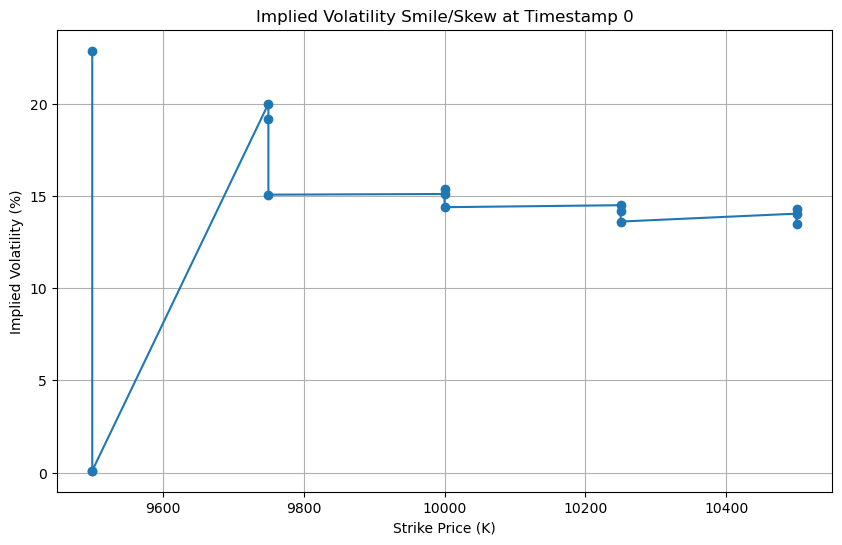

In [36]:
# Cell 6: Analysis and Interpretation

print("\nFull DataFrame with calculated metrics (Options only):")
df_options_results = df[df['product'].str.contains('VOUCHER')].copy()
print(df_options_results[['timestamp', 'product', 'mid_price', 'strike', 'Implied_Vol', 'Delta', 'Gamma', 'Vega', 'Theta']])

print("\n--- Interpretation Guide ---")
print("Implied_Vol (IV): Market's expectation of future volatility. High IV means options are expensive, low IV means cheap (relative to model/history). Compare IV across strikes (smile/skew) and time.")
print("Delta: Change in option price per $1 change in VOLCANIC_ROCK price. Ranges 0 to 1 for calls.")
print("   - Hedging: To hedge a SHORT call position (e.g., sold 1 voucher), BUY Delta units of VOLCANIC_ROCK.")
print("   - Hedging: To hedge a LONG call position (e.g., bought 1 voucher), SELL Delta units of VOLCANIC_ROCK.")
print("Gamma: Change in Delta per $1 change in VOLCANIC_ROCK price. Highest for at-the-money options near expiry. Shows how quickly your Delta hedge needs adjusting.")
print("Vega: Change in option price per 1 point change in Implied Volatility (e.g., IV from 0.50 to 0.51). Shows sensitivity to volatility changes. Important for volatility trading.")
print("Theta: Change in option price per day passing (time decay). Usually negative for long options (loses value over time) and positive for short options (gains value).")
print("-----------------------------")
print("\n!!! REMEMBER: These calculations depend HEAVILY on the assumed Time to Expiry (T) and Risk-Free Rate (r) !!!")
print("!!! Realistic values for T and r based on the simulation rules are ESSENTIAL for meaningful results. !!!")

# Example: Plotting the Volatility Smile/Skew for a single timestamp (if enough data)
timestamp_to_plot = 0 # Choose a timestamp present in the data
df_smile = df_options_results[df_options_results['timestamp'] == timestamp_to_plot].sort_values('strike')

if not df_smile.empty and df_smile['Implied_Vol'].notna().sum() > 1:
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    plt.plot(df_smile['strike'], df_smile['Implied_Vol'] * 100, marker='o') # Plot IV in percentage
    plt.title(f'Implied Volatility Smile/Skew at Timestamp {timestamp_to_plot}')
    plt.xlabel('Strike Price (K)')
    plt.ylabel('Implied Volatility (%)')
    plt.grid(True)
    plt.show()
else:
    print(f"\nNot enough data points with valid IV at timestamp {timestamp_to_plot} to plot a smile.")

In [37]:
# Cell 7: Strategy Implications & Hedging Example

print("\n--- Strategy & Hedging Implications ---")

# Delta Hedging Example:
# Suppose at timestamp 100, we are SHORT 10 contracts of VOLCANIC_ROCK_VOUCHER_10250
position_qty = -10
product_hedge = 'VOLCANIC_ROCK_VOUCHER_10250'
hedge_timestamp = 100

hedge_row = df_options_results[
    (df_options_results['timestamp'] == hedge_timestamp) &
    (df_options_results['product'] == product_hedge)
]

if not hedge_row.empty:
    option_delta = hedge_row['Delta'].iloc[0]
    if not pd.isna(option_delta):
        # Delta of our position = position_qty * option_delta
        position_delta = position_qty * option_delta
        # Amount of underlying to hold for hedge = -position_delta
        underlying_hedge_qty = -position_delta

        print(f"\nExample Delta Hedge @ Timestamp {hedge_timestamp}:")
        print(f"  Position: {position_qty} of {product_hedge}")
        print(f"  Option Delta: {option_delta:.4f}")
        print(f"  Position Delta: {position_delta:.4f}")
        print(f"  Required Hedge: Buy {underlying_hedge_qty:.4f} units of VOLCANIC_ROCK to be delta-neutral.")
        # In the simulation, you'd place orders to adjust your VOLCANIC_ROCK position towards this amount.
    else:
        print(f"\nCannot calculate hedge for {product_hedge} at timestamp {hedge_timestamp} (Delta is NaN).")
else:
     print(f"\nNo data found for {product_hedge} at timestamp {hedge_timestamp} to calculate hedge.")


print("\nOther Potential Strategy Insights:")
print("- Volatility Trading: If calculated IV seems unusually high or low compared to historical volatility (needs calculation) or expectations, consider selling (high IV) or buying (low IV) options/spreads (Vega exposure).")
print("- Relative Value: Compare IV across different strikes and expirations (if available). Look for mispricings relative to the expected smile/skew.")
print("- Premium Decay: If IV is high and you expect volatility to drop or the price to stay stable, selling options (positive Theta) might be attractive (e.g., short calls/spreads).")
print("- Directional Bets with Defined Risk: Use spreads (Bull Call Spread, Bear Call Spread) based on Delta/Gamma and your price outlook, limiting risk compared to naked options.")

print("\nRemember the simulation constraints: You cannot exercise, so all strategies involve buying/selling the option contract itself before expiry.")


--- Strategy & Hedging Implications ---

Example Delta Hedge @ Timestamp 100:
  Position: -10 of VOLCANIC_ROCK_VOUCHER_10250
  Option Delta: 0.8528
  Position Delta: -8.5275
  Required Hedge: Buy 8.5275 units of VOLCANIC_ROCK to be delta-neutral.

Other Potential Strategy Insights:
- Volatility Trading: If calculated IV seems unusually high or low compared to historical volatility (needs calculation) or expectations, consider selling (high IV) or buying (low IV) options/spreads (Vega exposure).
- Relative Value: Compare IV across different strikes and expirations (if available). Look for mispricings relative to the expected smile/skew.
- Premium Decay: If IV is high and you expect volatility to drop or the price to stay stable, selling options (positive Theta) might be attractive (e.g., short calls/spreads).
- Directional Bets with Defined Risk: Use spreads (Bull Call Spread, Bear Call Spread) based on Delta/Gamma and your price outlook, limiting risk compared to naked options.

Remem

In [39]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-darkgrid')


In [40]:
# Cell 8: Prepare DataFrames for Plotting

# Ensure the absolute timestamp column exists on the options results df
# (It was calculated in Cell 4 as 'current_total_timestamp')
if 'current_total_timestamp' not in df.columns:
     df['current_total_timestamp'] = df['day'] * TIMESTAMPS_PER_DAY + df['timestamp']

# Create a DataFrame for the underlying asset ('VOLCANIC_ROCK') from the original data
df_underlying = df_prices[df_prices['product'] == 'VOLCANIC_ROCK'].copy()
if 'current_total_timestamp' not in df_underlying.columns:
     df_underlying['current_total_timestamp'] = df_underlying['day'] * TIMESTAMPS_PER_DAY + df_underlying['timestamp']

# Sort both DataFrames by the absolute timestamp for correct line plotting
df.sort_values(by='current_total_timestamp', inplace=True)
df_underlying.sort_values(by='current_total_timestamp', inplace=True)

print("DataFrames prepared for plotting.")
print(f"Options data points: {len(df)}")
print(f"Underlying data points: {len(df_underlying)}")

DataFrames prepared for plotting.
Options data points: 150000
Underlying data points: 30000


In [48]:
# Cell 7b: Define Timestamp Formatting Function

import matplotlib.ticker as ticker

# Make sure this matches the value used in calculations
TIMESTAMPS_PER_DAY_FORMATTER = 1_000_000

def format_sim_time(x, pos):
    """
    Formats an absolute timestamp tick value into 'Day X, Timestamp Y' string.
    """
    # Ignore matplotlib's position argument 'pos' usually
    x_int = int(x) # Work with integer part
    if x_int < 0: # Handle potential negative values if axis limits go below 0
        return ""
    day = x_int // TIMESTAMPS_PER_DAY_FORMATTER
    ts_within_day = x_int % TIMESTAMPS_PER_DAY_FORMATTER
    # Format timestamp with commas for readability
    return f"Day {day}, {ts_within_day:,}"

print("Timestamp formatting function defined.")

Timestamp formatting function defined.



Generating separate Delta plots for each voucher...


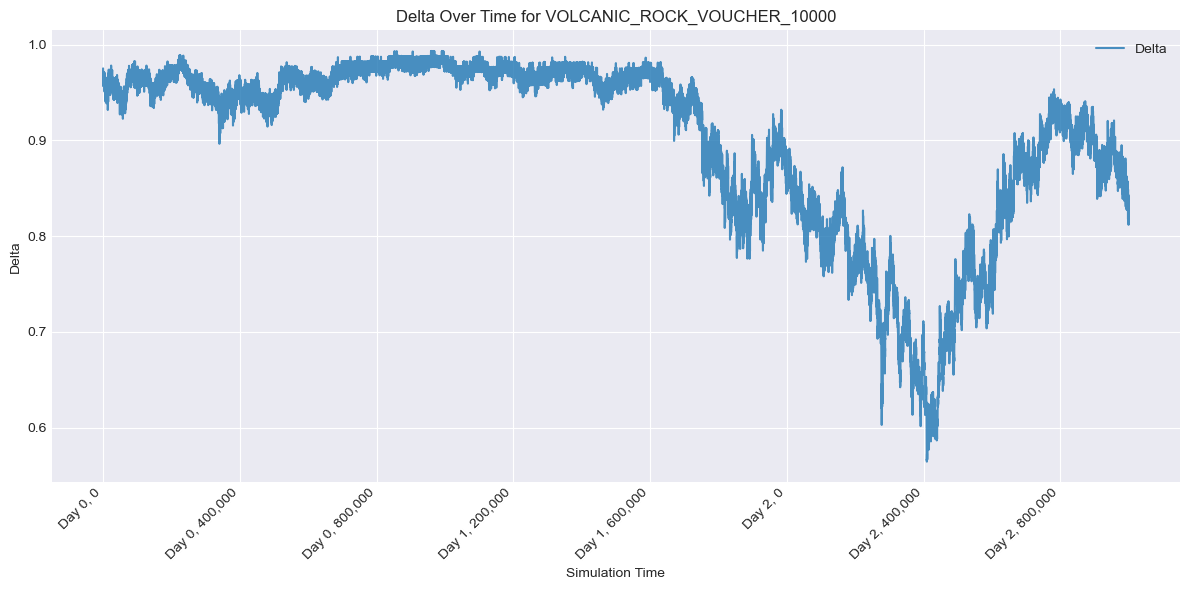

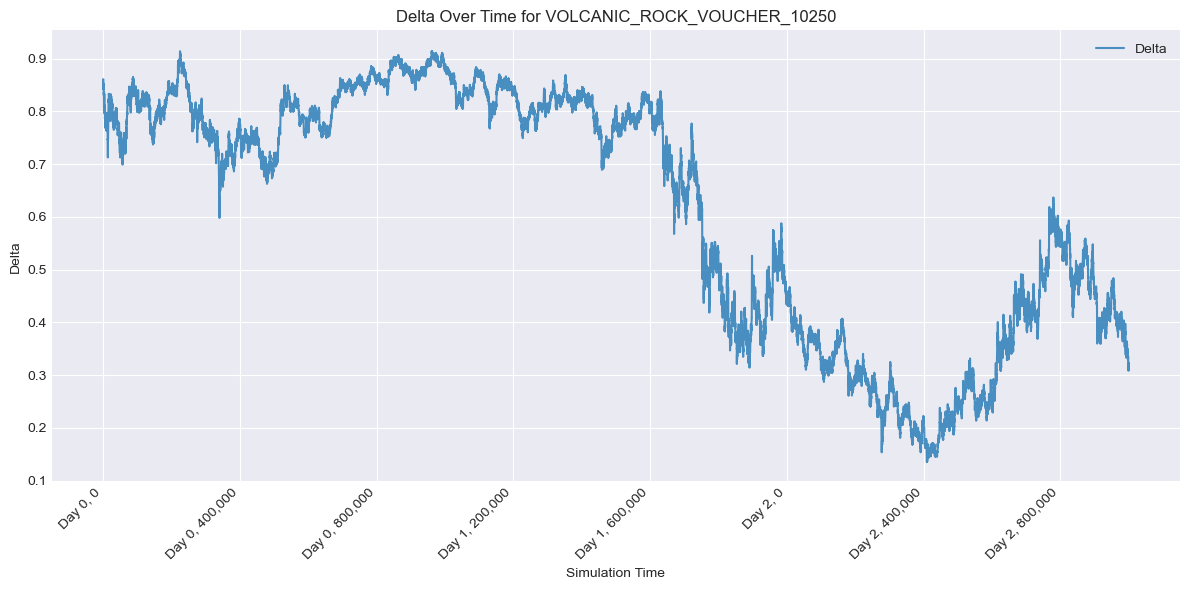

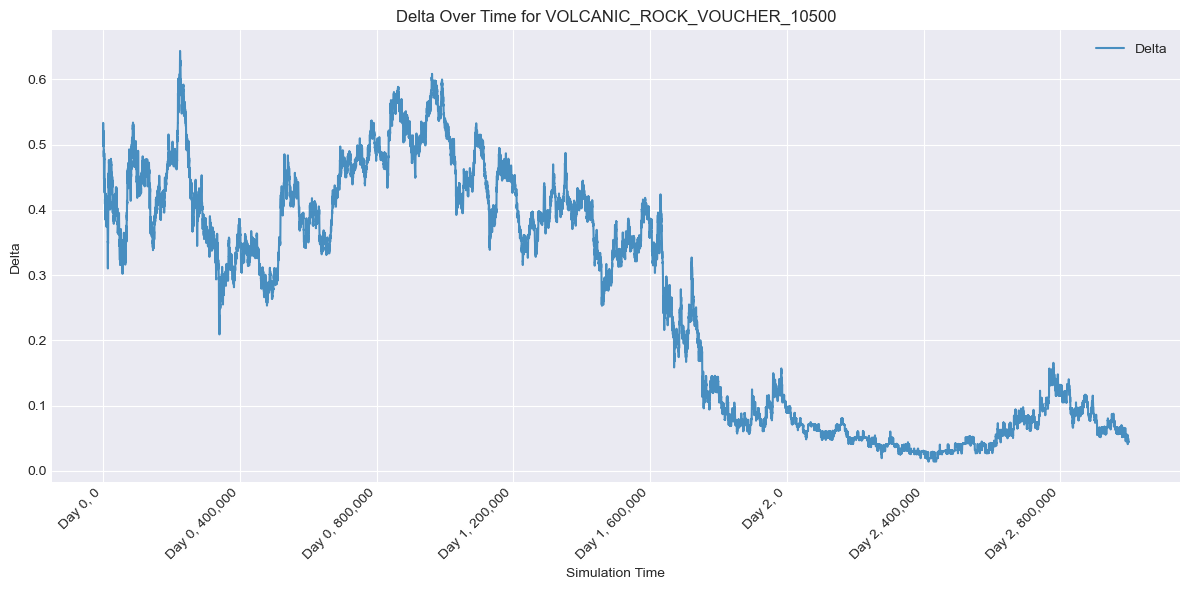

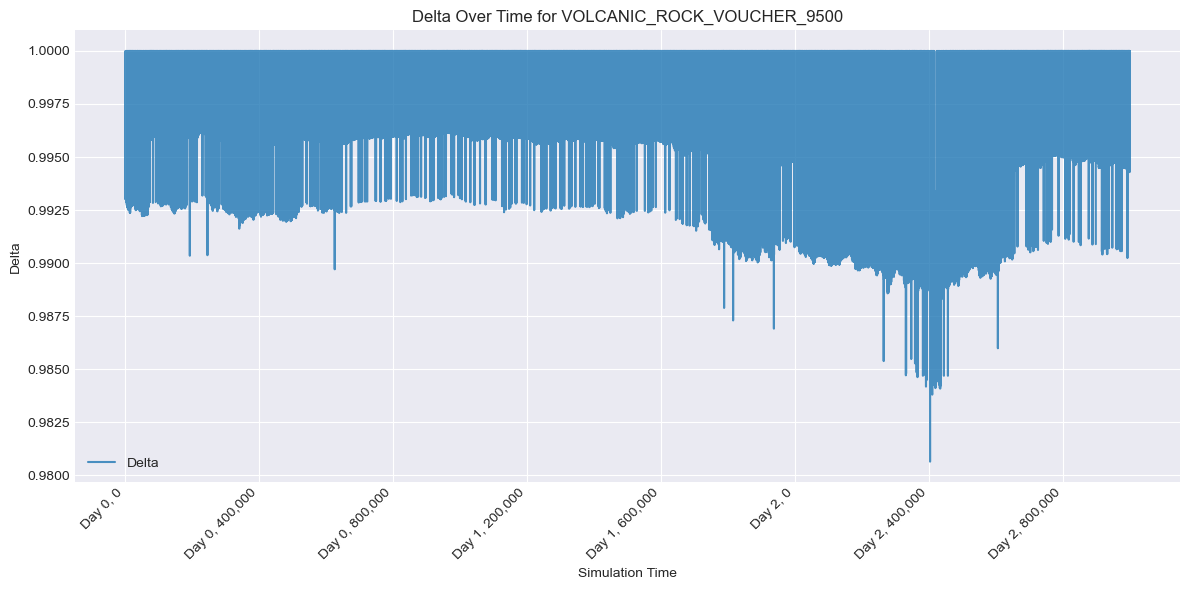

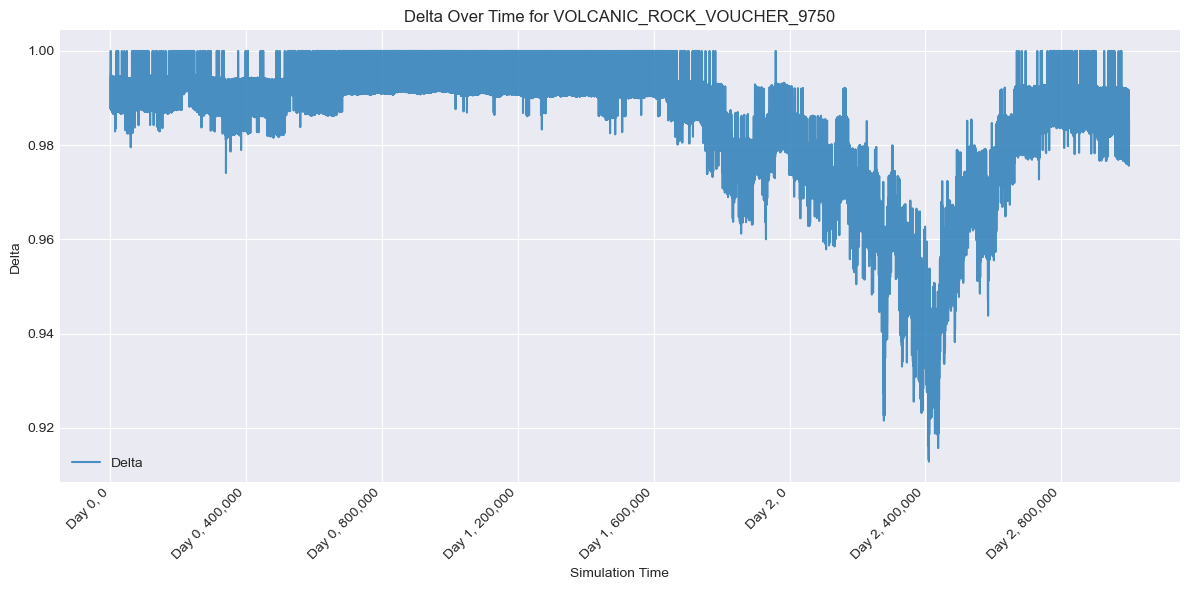


Finished generating Delta plots.


In [54]:


# Make sure the formatting function and constant are available
# (Assuming Cell 7b or equivalent was run)
if 'format_sim_time' not in locals():
    print("Warning: format_sim_time function not defined. Redefining.")
    TIMESTAMPS_PER_DAY_FORMATTER = 1_000_000
    def format_sim_time(x, pos):
        x_int = int(x); day = x_int // TIMESTAMPS_PER_DAY_FORMATTER
        ts_within_day = x_int % TIMESTAMPS_PER_DAY_FORMATTER
        return f"Day {day}, {ts_within_day:,}"

print("\nGenerating separate Delta plots for each voucher...")

# Check if the options dataframe 'df' exists and is not empty
if 'df' not in locals() or df.empty:
    print("Options DataFrame 'df' not found or is empty. Cannot generate plots.")
else:
    # Group by option product (which includes the strike)
    for product_name, group_data in df.groupby('product'):

        # Check if there's valid Delta data for this specific group
        if group_data['Delta'].notna().any():

            # Create a NEW figure for each product
            plt.figure(figsize=(12, 6))

            # Plot Delta data for the current group
            plt.plot(group_data['current_total_timestamp'],
                     group_data['Delta'],
                     label='Delta', # Simple label for the line
                     alpha=0.8)

            # Set title specific to the product
            plt.title(f'Delta Over Time for {product_name}')
            plt.xlabel('Simulation Time')
            plt.ylabel('Delta')
            plt.legend() # Show legend for the Delta line
            plt.grid(True)

            # --- Add Axis Formatting ---
            ax = plt.gca()
            ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=10, integer=True))
            # Apply the custom formatting function
            ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_sim_time))
            plt.xticks(rotation=45, ha='right')
            # --- End Formatting ---

            plt.tight_layout() # Adjust layout
            plt.show() # Display the plot for the current product

        else:
            print(f"No valid Delta data to plot for {product_name}")

print("\nFinished generating Delta plots.")

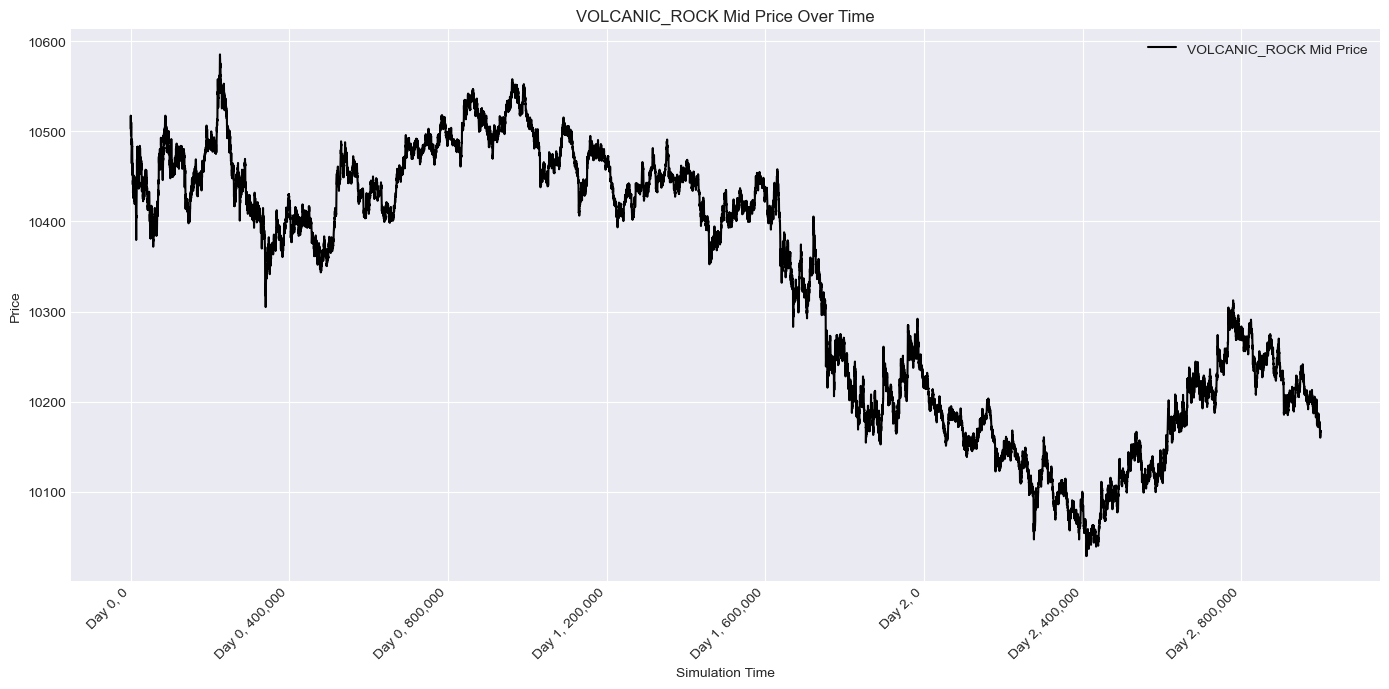

In [50]:


plt.figure(figsize=(14, 7))

# --- (Plotting code remains the same) ---
plt.plot(df_underlying['current_total_timestamp'], df_underlying['mid_price'], label='VOLCANIC_ROCK Mid Price', color='black')

plt.title('VOLCANIC_ROCK Mid Price Over Time')
plt.xlabel('Simulation Time') # Updated label
plt.ylabel('Price')
plt.legend()
plt.grid(True)

# --- Add Axis Formatting ---
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=10, integer=True))
# Apply the custom formatting function
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_sim_time))
plt.xticks(rotation=45, ha='right')
# --- End Formatting ---

plt.tight_layout()
plt.show()

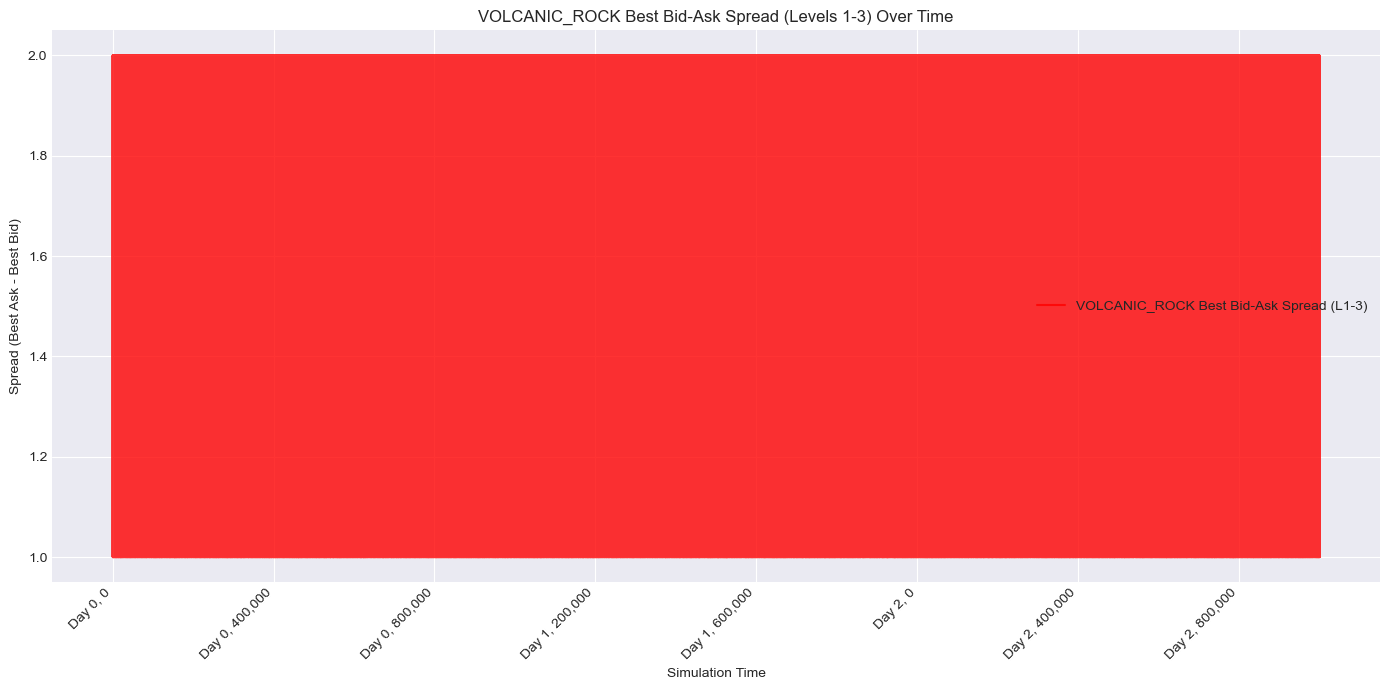

In [51]:
# Cell 11: Plot Volcanic Rock BEST Bid-Ask Spread Over Time (Across Levels 1-3)

# Define the columns for bids and asks
bid_cols = ['bid_price_1', 'bid_price_2', 'bid_price_3']
ask_cols = ['ask_price_1', 'ask_price_2', 'ask_price_3']

# Select the underlying dataframe
df_underlying = df_prices[df_prices['product'] == 'VOLCANIC_ROCK'].copy()
if 'current_total_timestamp' not in df_underlying.columns:
     df_underlying['current_total_timestamp'] = df_underlying['day'] * TIMESTAMPS_PER_DAY + df_underlying['timestamp']
df_underlying.sort_values(by='current_total_timestamp', inplace=True)


# --- Calculate Best Bid and Best Ask across levels ---
# Ensure relevant columns are numeric, coercing errors which might arise from empty strings etc.
for col in bid_cols + ask_cols:
    if col in df_underlying.columns:
        df_underlying[col] = pd.to_numeric(df_underlying[col], errors='coerce')
    else:
        # If a column is missing entirely (e.g., only level 1 data), create it with NaN
        print(f"Warning: Column {col} not found in underlying data. Filling with NaN.")
        df_underlying[col] = np.nan


# Find the highest bid price across the defined columns for each row
# skipna=True ensures that if only bid_price_1 exists, it's used, etc.
df_underlying['best_overall_bid'] = df_underlying[bid_cols].max(axis=1, skipna=True)

# Find the lowest ask price across the defined columns for each row
df_underlying['best_overall_ask'] = df_underlying[ask_cols].min(axis=1, skipna=True)

# Calculate the spread between the best ask and best bid
df_underlying['bid_ask_spread'] = df_underlying['best_overall_ask'] - df_underlying['best_overall_bid']

# Drop rows where spread couldn't be calculated (e.g., no valid bids OR no valid asks found across levels 1-3)
initial_rows = len(df_underlying)
df_underlying.dropna(subset=['bid_ask_spread'], inplace=True)
rows_after_drop = len(df_underlying)
if initial_rows > rows_after_drop:
    print(f"Dropped {initial_rows - rows_after_drop} rows where best bid/ask spread could not be calculated.")
# --- End Calculation ---


# --- Plotting ---
plt.figure(figsize=(14, 7))

if not df_underlying.empty:
    plt.plot(df_underlying['current_total_timestamp'], df_underlying['bid_ask_spread'], label='VOLCANIC_ROCK Best Bid-Ask Spread (L1-3)', color='red', alpha=0.8)
    plt.title('VOLCANIC_ROCK Best Bid-Ask Spread (Levels 1-3) Over Time')
    plt.xlabel('Simulation Time') # Updated label
    plt.ylabel('Spread (Best Ask - Best Bid)')
    plt.legend()
    plt.grid(True)
else:
    # ... (handling for empty data) ...
    pass # Keep the previous handling

# --- Add Axis Formatting ---
# Only format if there was data
if not df_underlying.empty:
    ax = plt.gca()
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=10, integer=True))
    # Apply the custom formatting function
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_sim_time))
    plt.xticks(rotation=45, ha='right')
# --- End Formatting ---

plt.tight_layout()
plt.show()


Generating separate spread plots for each voucher...


<Figure size 1400x700 with 0 Axes>

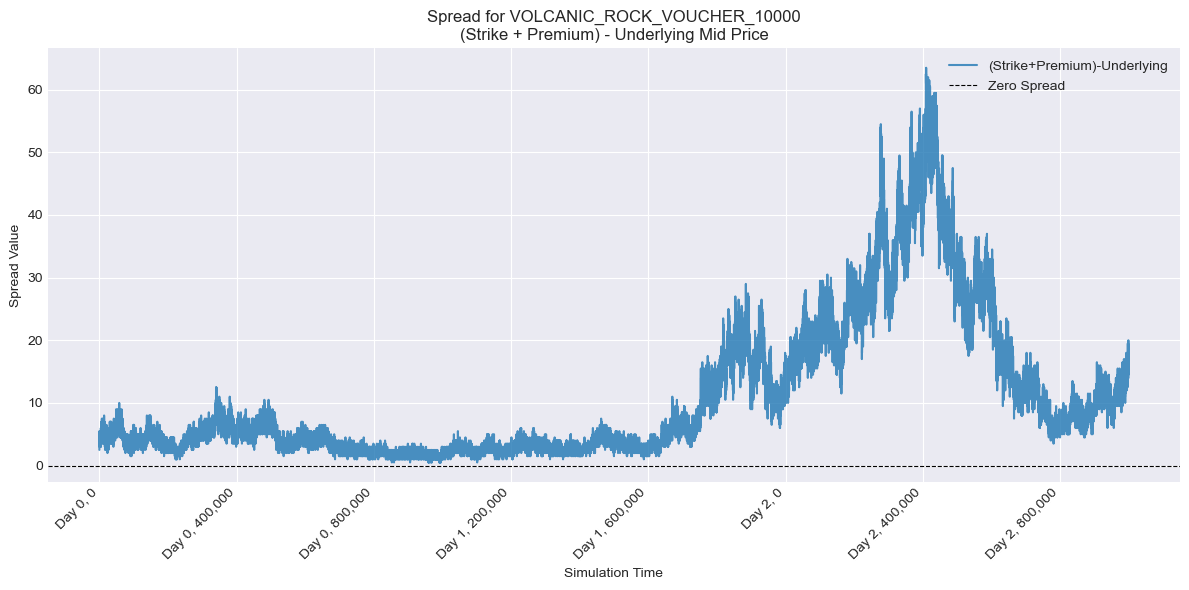

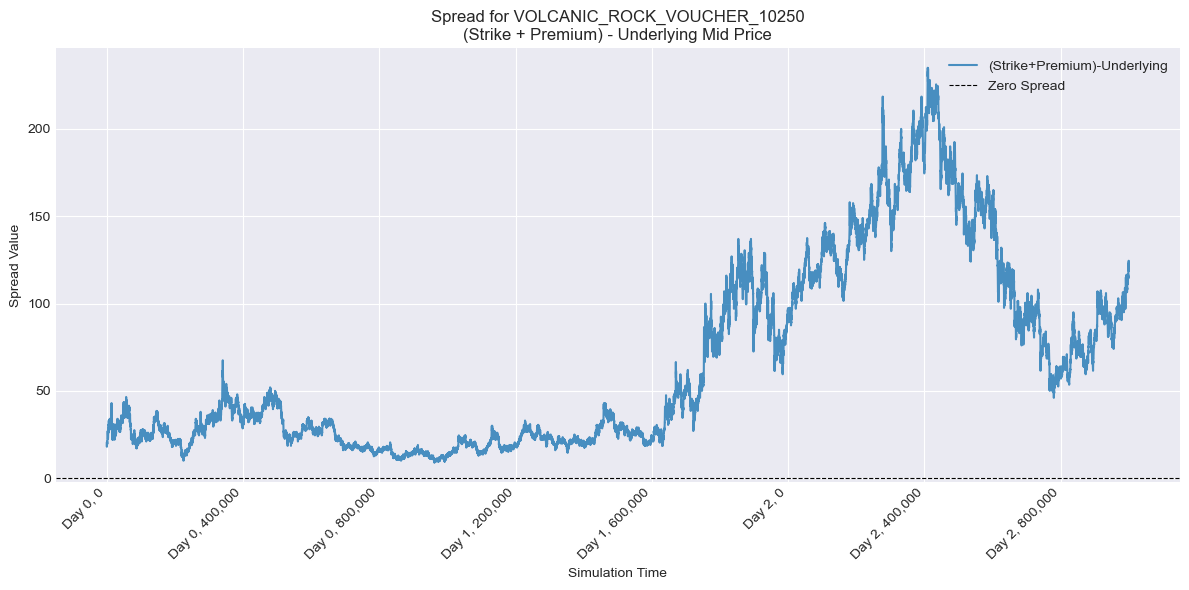

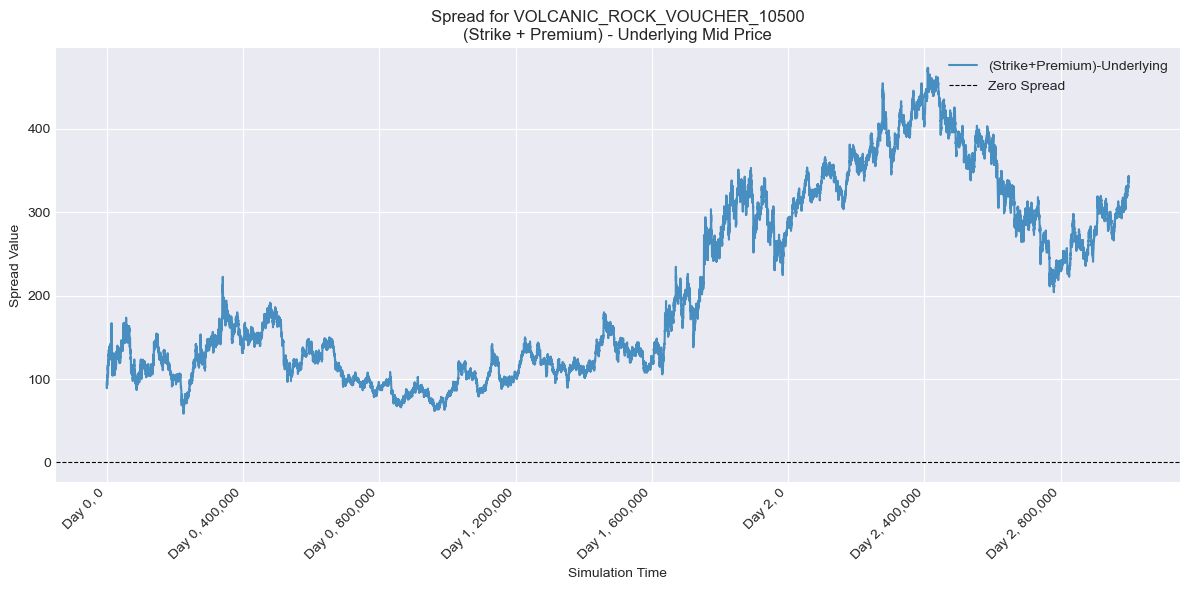

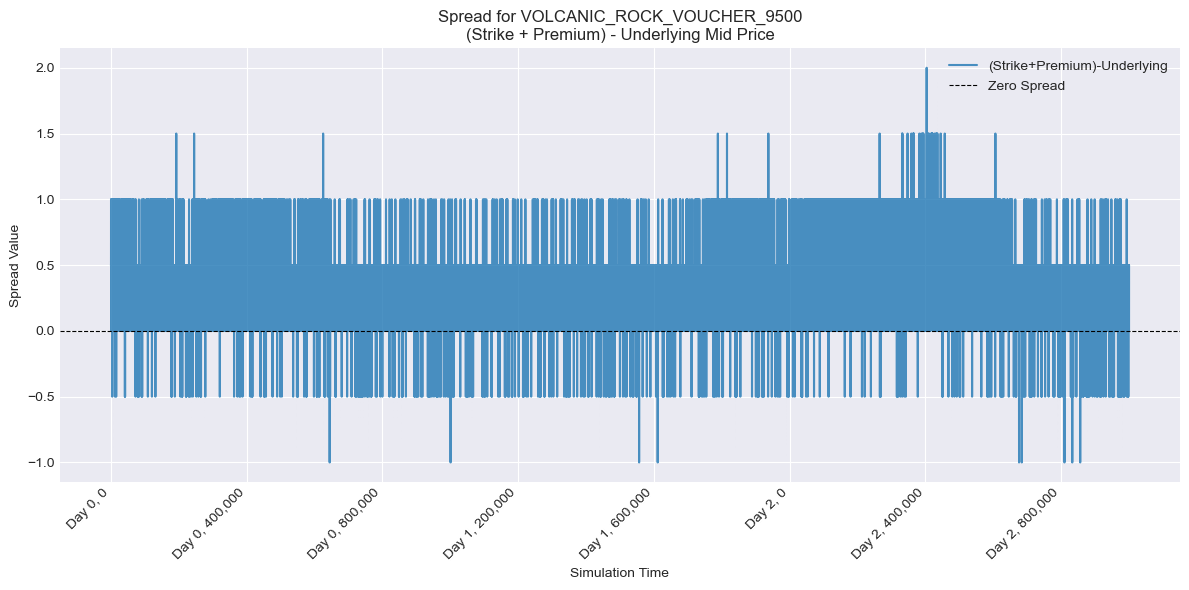

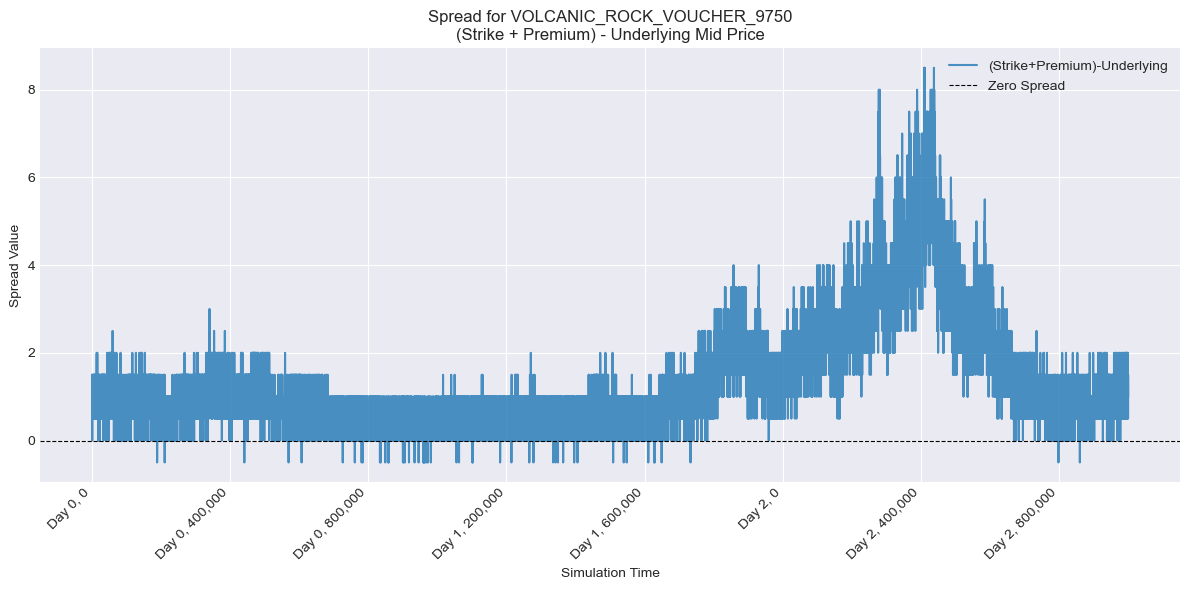


Finished generating spread plots.


In [53]:
# Cell 12: Plot Spread: (Strike + Premium) - Underlying Price

# We need to add the underlying price to the options dataframe for easier calculation
# Use the multi-index map created earlier. Reset index to allow merging.
underlying_prices_to_merge = underlying_price_map.reset_index()
underlying_prices_to_merge.rename(columns={'mid_price': 'underlying_mid_price'}, inplace=True)

# Merge underlying price onto the options dataframe
# Ensure df has 'day' and 'timestamp' if they were somehow dropped
if 'day' not in df.columns: df = pd.merge(df, df_prices[['product', 'timestamp', 'day']].drop_duplicates(), on=['product', 'timestamp'], how='left')
df_plot_spread = pd.merge(df, underlying_prices_to_merge, on=['day', 'timestamp'], how='left')

# Calculate the spread
df_plot_spread['strike_plus_premium'] = df_plot_spread['strike'] + df_plot_spread['mid_price'] # mid_price here is the premium
df_plot_spread['exercise_spread'] = df_plot_spread['strike_plus_premium'] - df_plot_spread['underlying_mid_price']

# Plotting
plt.figure(figsize=(14, 7))

# --- Plotting Loop (Separate Plot for Each Product) ---
print("\nGenerating separate spread plots for each voucher...")

# Check if data exists before looping
if 'df_plot_spread' not in locals() or df_plot_spread.empty:
    print("No data available in df_plot_spread to generate plots.")
else:
    # Group by option product (which includes the strike)
    for product_name, group_data in df_plot_spread.groupby('product'):

        # Check if there's valid spread data for this specific group
        if group_data['exercise_spread'].notna().any():

            # Create a NEW figure for each product
            plt.figure(figsize=(12, 6)) # Slightly smaller figure size might be good

            # Plot data for the current group
            plt.plot(group_data['current_total_timestamp'],
                     group_data['exercise_spread'],
                     label='(Strike+Premium)-Underlying', # Simple label for the line
                     alpha=0.8)

            # Set title specific to the product
            plt.title(f'Spread for {product_name}\n(Strike + Premium) - Underlying Mid Price')
            plt.xlabel('Simulation Time')
            plt.ylabel('Spread Value')
            plt.axhline(0, color='black', linestyle='--', linewidth=0.8, label='Zero Spread')
            plt.legend() # Show legend for the line and the zero line
            plt.grid(True)

            # --- Add Axis Formatting ---
            ax = plt.gca()
            ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=10, integer=True))
            ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_sim_time))
            plt.xticks(rotation=45, ha='right')
            # --- End Formatting ---

            plt.tight_layout() # Adjust layout
            plt.show() # Display the plot for the current product

        else:
            print(f"No valid spread data to plot for {product_name}")

print("\nFinished generating spread plots.")